# Fine Tune

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import torch
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset

import tqdm as tqdm

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Dataset

In [2]:
mbti_df = pd.read_csv('../processed/all_data_3.csv')

In [3]:
mbti_df

,Unnamed: 0,type,tweet
0,0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl..."
1,1,ISFJ,Tinder has your health in mind.
2,2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker
3,3,ISFJ,Outstanding faculty from and more at Winter Co...
4,4,ISFJ,"Using pray and wait on God, can be a means of ..."
...,...,...,...
106322,106322,ESTP,This is so legit holy shit lol I work in rando...
106323,106323,ESTP,Same here When Im in a group Im fairly quiet u...
106324,106324,ESTJ,Im more worried about the idea that we are sla...
106325,106325,ESTP,Believing you dont have ethics is still an eth...


### Add column `introvert_extrovert`

In [4]:
mbti_df['intuition_sensing'] = mbti_df['type'].apply(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')

In [5]:
mbti_df.sample(10)

,Unnamed: 0,type,tweet,intuition_sensing
63912,63912,INTP,thank you all for your replies this community ...,Intuition
10099,10099,ENFP,have you ever been a public setting where some...,Intuition
48009,48009,INFP,i think your avatar sums it all up pretty well...,Intuition
71910,71910,ISFP,Just ignore this person You didnt ask for opin...,Sensing
19481,19481,ENTJ,it will take awhile for me but thats only beca...,Intuition
38097,38097,INFJ,wow really it depends on what you find intelle...,Intuition
94340,94340,ESFJ,im sure you are right that it does take a shit...,Sensing
71619,71619,ISFP,color come to realize that i need to spend mor...,Sensing
82674,82674,ISTP,Ah yea youtube has never and will never be MP3...,Sensing
20163,20163,ENTJ,Oh you know why I stated she was bipolar Tell ...,Intuition


### Consider only posts with length < 32 words

In [6]:
mbti_df = mbti_df[mbti_df['tweet'].str.split().str.len() < 32]

In [7]:
mbti_df

,Unnamed: 0,type,tweet,intuition_sensing
0,0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl...",Sensing
1,1,ISFJ,Tinder has your health in mind.,Sensing
2,2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker,Sensing
3,3,ISFJ,Outstanding faculty from and more at Winter Co...,Sensing
4,4,ISFJ,"Using pray and wait on God, can be a means of ...",Sensing
...,...,...,...,...
106313,106313,ESTP,True I do end up the mentor but I feel like Yo...,Sensing
106321,106321,ESFP,LOL and thats why I got sort of mad because th...,Sensing
106322,106322,ESTP,This is so legit holy shit lol I work in rando...,Sensing
106324,106324,ESTJ,Im more worried about the idea that we are sla...,Sensing


In [8]:
mbti_df = mbti_df.drop(columns=['Unnamed: 0'])

In [9]:
mbti_df.sample(10)

,type,tweet,intuition_sensing
64561,INTP,I can stare into someones eyes possibly foreve...,Intuition
14471,ENFP,welcome i hope you have fun most people here a...,Intuition
43686,INFP,i dreamt that i was a celebrity it was so depr...,Intuition
402,ISFJ,"Today, with hope rather than fear.",Sensing
81752,ISTP,In a nonprojective way please so that I dont h...,Sensing
30352,ENTP,Oh I dont fit in lol But thanks for the advice...,Intuition
59393,INTP,Bring food and water Maybe a neck pillow If yo...,Intuition
85617,ISTP,Heyo Former Austinite here We went to a vintag...,Sensing
51651,INTJ,no you start itrolleyestongue this is a sword ...,Intuition
100128,ESFP,Davis is I s t j Jaime is e s t p Ramsey e n t...,Sensing


C:\Users\fizuf\AppData\Local\Temp\ipykernel_23156\1952733437.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mbti_df_grouped, x='intuition_sensing', y='n_posts', palette='husl')


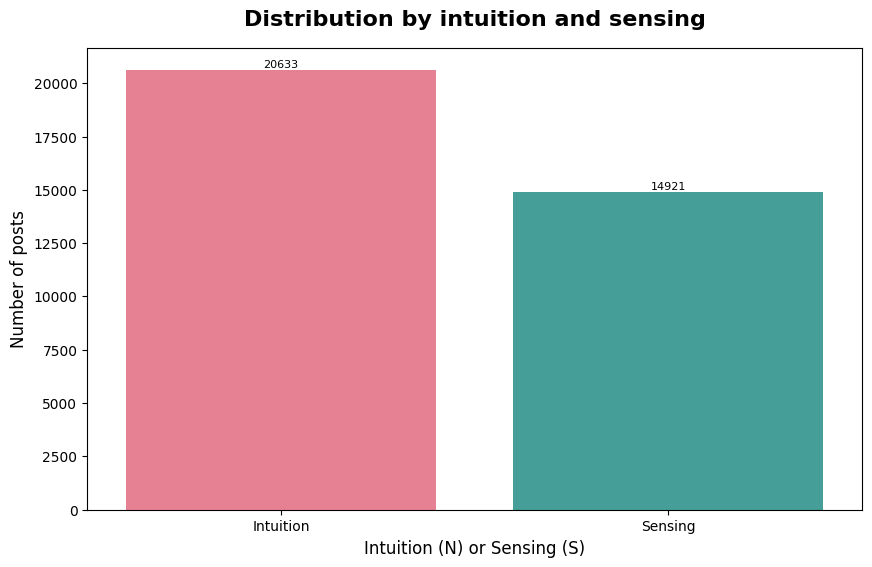

In [10]:
mbti_df_grouped = mbti_df.groupby('intuition_sensing').size().reset_index(name='n_posts')
mbti_df_grouped = mbti_df_grouped.sort_values(by='n_posts', ascending=False)
mbti_df_grouped.columns = ['intuition_sensing', 'n_posts']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mbti_df_grouped, x='intuition_sensing', y='n_posts', palette='husl')

# Add annotations (number of users above each bar)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=8, color='black')

plt.title('Distribution by intuition and sensing', fontsize=16, fontweight='bold', pad=16)
plt.xlabel('Intuition (N) or Sensing (S)', fontsize=12)
plt.ylabel('Number of posts', fontsize=12)

plt.show()

In [11]:
mbti_labels_dict = {
    'Intuition': 0,
    'Sensing': 1,
}

### Split datasets

In [12]:
X = mbti_df['tweet']
y = mbti_df['intuition_sensing']

y = y.map(mbti_labels_dict)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


### Fine Tune BERT

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  
model.config.hidden_dropout_prob = 0.3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
inputs = tokenizer(X.tolist(), padding=True, truncation=True, max_length=32, return_tensors='pt')
labels = torch.tensor(y.values) 

train_dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [16]:
import joblib

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

losses = []
acc = []
prec = []
recalls = []
f1score = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Calculate loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        
        # Track predictions and labels
        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(train_dataloader)

    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")
    
    # Calculate metrics (accuracy, precision, recall, F1-score)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    acc.append(accuracy)
    prec.append(precision)
    recalls.append(recall)
    f1score.append(f1)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


joblib.dump(model, 'data/model_4.joblib')
joblib.dump(tokenizer, 'data/tokenizer_4.joblib')

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: 0.6758029142772937
Accuracy: 0.5834, Precision: 0.5598, Recall: 0.5834, F1-Score: 0.5230
Epoch 2/10, Loss: 0.6363924746341755
Accuracy: 0.6316, Precision: 0.6245, Recall: 0.6316, F1-Score: 0.6101
Epoch 3/10, Loss: 0.548577724891334
Accuracy: 0.7161, Precision: 0.7138, Recall: 0.7161, F1-Score: 0.7111
Epoch 4/10, Loss: 0.3687905502244639
Accuracy: 0.8370, Precision: 0.8365, Recall: 0.8370, F1-Score: 0.8361
Epoch 5/10, Loss: 0.20798665793986085
Accuracy: 0.9164, Precision: 0.9163, Recall: 0.9164, F1-Score: 0.9162
Epoch 6/10, Loss: 0.11973427595920229
Accuracy: 0.9540, Precision: 0.9539, Recall: 0.9540, F1-Score: 0.9539
Epoch 7/10, Loss: 0.08551960929798484
Accuracy: 0.9671, Precision: 0.9670, Recall: 0.9671, F1-Score: 0.9670
Epoch 8/10, Loss: 0.06612746879513942
Accuracy: 0.9752, Precision: 0.9752, Recall: 0.9752, F1-Score: 0.9752
Epoch 9/10, Loss: 0.05453462919212398
Accuracy: 0.9797, Precision: 0.9797, Recall: 0.9797, F1-Score: 0.9797
Epoch 10/10, Loss: 0.044322633130

['data/tokenizer_4.joblib']

In [31]:
import joblib

joblib.dump(model, 'data/model_3.joblib')
joblib.dump(tokenizer, 'data/tokenizer_3.joblib')

['data/tokenizer_3.joblib']

### Loss

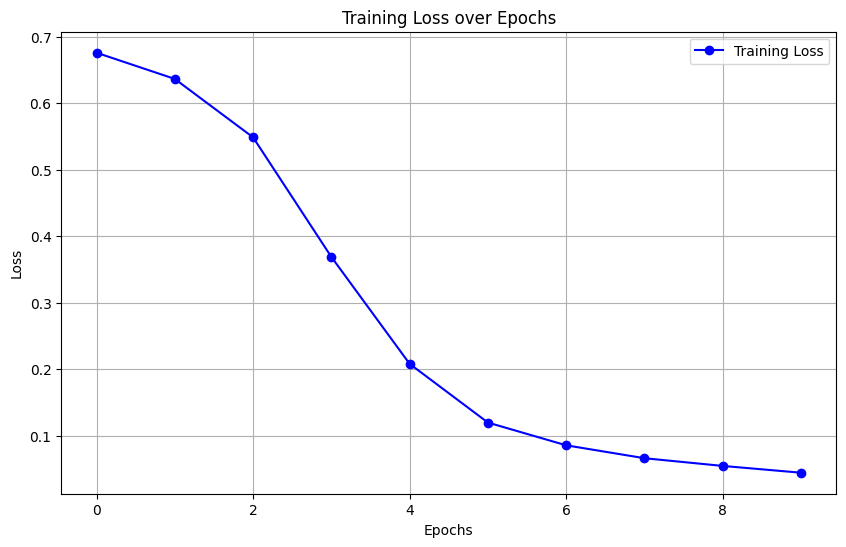

In [17]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(losses, label='Training Loss', color='b', marker='o')  # Plot losses
plt.title('Training Loss over Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show gridlines for better readability
plt.show()  # Display the plot

### Accuracy, precision, recall, and f1-score

In [18]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(all_preds, all_labels))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14462
           1       0.98      0.98      0.98     10425

    accuracy                           0.98     24887
   macro avg       0.98      0.98      0.98     24887
weighted avg       0.98      0.98      0.98     24887



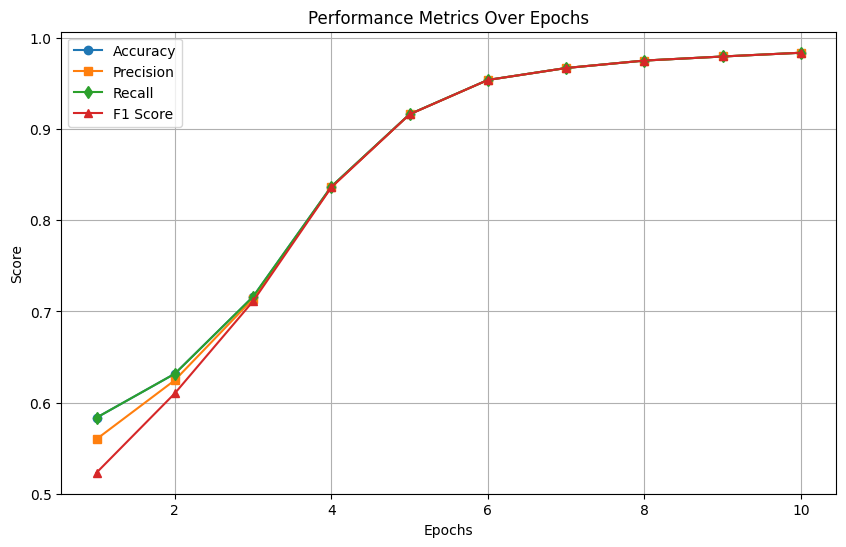

In [19]:
epochs = range(1, len(acc) + 1)

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Accuracy', marker='o')
plt.plot(epochs, prec, label='Precision', marker='s')
plt.plot(epochs, recalls, label='Recall', marker='d')
plt.plot(epochs, f1score, label='F1 Score', marker='^')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Performance Metrics Over Epochs')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Evaluation

In [2]:
import joblib 

model = joblib.load('data/model_2.joblib')
tokenizer = joblib.load('data/tokenizer_2.joblib')

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
import torch

model.eval()  # Set model to evaluation mode

val_preds = []
val_labels = []
all_attentions = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions
        all_attentions.append(attentions)
        logits = outputs.logits
        preds = logits.argmax(dim=-1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
                        
    # Validation metrics
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

    print(f"Testing - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

# Print classification report using val_preds and val_labels
print(classification_report(val_labels, val_preds))


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Testing - Accuracy: 0.5750, Precision: 0.5716, Recall: 0.5750, F1-Score: 0.5729
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      6184
           1       0.49      0.46      0.48      4483

    accuracy                           0.58     10667
   macro avg       0.56      0.56      0.56     10667
weighted avg       0.57      0.58      0.57     10667



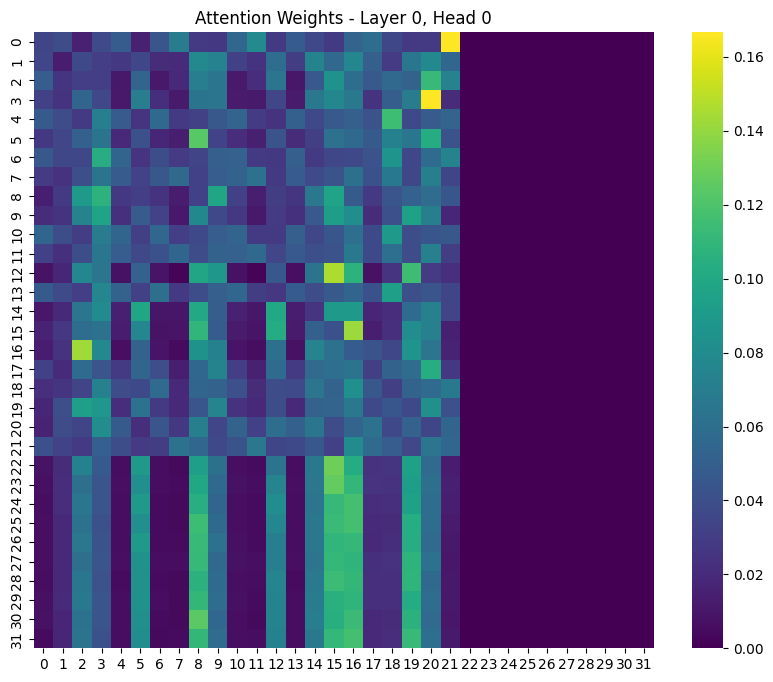

In [21]:
layer = 0  # First layer
head = 0   # First attention head
attention_weights = attentions[layer][0, head].cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, annot=False, cmap='viridis')
plt.title(f"Attention Weights - Layer {layer}, Head {head}")
plt.show()